In [113]:
import rioxarray
from rioxarray.merge import merge_arrays
import xarray
from rasterio.features import shapes, geometry_mask
from shapely import geometry
from shapely.geometry import shape, mapping, MultiPolygon
from rasterio.mask import mask
import rasterio

In [114]:
filepath = '/Users/eslt0101/Data/eScience/IceShelves/TestDataSet/S2_comp_first.tif'


In [115]:
bands = rioxarray.open_rasterio(filepath)

In [116]:
#src = rasterio.open(filepath)

In [117]:
bands


<xarray.DataArray (band: 3, y: 10002, x: 10004)>
[300180024 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1 2 3
  * y            (y) float64 -2.667e+05 -2.667e+05 ... -3.667e+05 -3.667e+05
  * x            (x) float64 -1.654e+06 -1.654e+06 ... -1.554e+06 -1.554e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B4_first', 'B3_first', 'B2_first')
    grid_mapping:  spatial_ref

In [118]:
bandstransform = bands.rio.transform()

In [119]:
#bbox = bands.rio.transform_bounds("WGS84")

In [120]:
#bbox


In [121]:
bands.rio.bounds()


(-1653920.0, -366670.0, -1553880.0, -266650.0)

In [122]:
bands.rio.crs

CRS.from_epsg(3031)

In [123]:
p1=geometry.Point([-1601000.0, -300000.0])
p2=geometry.Point([-1601000.0, -280000.0])
p3=geometry.Point([-1580000.0, -280000.0])
p4=geometry.Point([-1580000.0, -300000.0])
plist1 = [p1,p2,p3,p4]

p5=geometry.Point([-1651000.0, -360000.0])
p6=geometry.Point([-1651000.0, -350000.0])
p7=geometry.Point([-1640000.0, -350000.0])
p8=geometry.Point([-1640000.0, -360000.0])
plist2 = [p5,p6,p7,p8]

In [124]:
poly1 = geometry.Polygon([[p.x,p.y] for p in plist1])
poly2 = geometry.Polygon([[p.x,p.y] for p in plist2])

In [125]:
type(poly1)

shapely.geometry.polygon.Polygon

In [126]:
from geopandas import GeoSeries

In [127]:
polys = GeoSeries([poly1,poly2],crs=bands.spatial_ref.crs_wkt)

In [128]:
polys

0    POLYGON ((-1601000.000 -300000.000, -1601000.0...
1    POLYGON ((-1651000.000 -360000.000, -1651000.0...
dtype: geometry

In [129]:
import json
from shapely.wkt import loads
import shapely.geometry as geometry


In [130]:
#a=json.loads(geomstr)

In [131]:
#type(a)


In [132]:
#a

In [133]:
#type(a['coordinates'])

In [134]:
#mshape = shape(a['coordinates'])

In [135]:
#bands.rio.transform()




In [136]:
mmask = geometry_mask(polys,out_shape=(len(bands.y),len(bands.x)),transform=bands.rio.transform(),invert=True)


In [137]:
type(mmask)

numpy.ndarray

In [138]:
mmask.shape


(10002, 10004)

In [139]:
def boolstr_to_floatstr(v):
    if v == 'True':
        return '1'
    elif v == 'False':
        return '0'
    else:
        return v
    

In [142]:
m2mask = np.vectorize(boolstr_to_floatstr)(mmask).astype(np.dtype('uint16'))

In [36]:
from rioxarray.rioxarray import XRasterBase as xrb

In [37]:
from rioxarray.rioxarray import RasterArray as rar


In [38]:
m2mask = xarray.core.dataarray.DataArray(mmask)

In [39]:
type(m2mask)

xarray.core.dataarray.DataArray

In [143]:
amask= xarray.DataArray(data=m2mask,dims=['y','x'],coords={'y':bands[0].coords['y'],'x':bands[0].coords['x']})

In [144]:
amask

<xarray.DataArray (y: 10002, x: 10004)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
Coordinates:
  * y        (y) float64 -2.667e+05 -2.667e+05 ... -3.667e+05 -3.667e+05
  * x        (x) float64 -1.654e+06 -1.654e+06 ... -1.554e+06 -1.554e+06

In [145]:
#m2mask

In [146]:
#bands

In [147]:
#print(bands[0].coords['y'])

In [148]:
from rioxarray.rioxarray import _add_attrs_proj

In [149]:
#nmask = m2mask.copy()

In [150]:
#nmask

In [151]:
#nnmask = _add_attrs_proj(nmask,bands[0])

In [152]:
#fmask = nmask.copy(deep=True)

In [153]:
#print(fmask.rio._x_dim)

In [154]:
#fmask.rio._y_dim = bands[0].rio.y_dim

In [155]:
#fmask

In [156]:
#fmask.rio.write_crs(bands[0].rio.crs,inplace=True)

In [157]:
#data_obj = fmask.rio._get_obj(inplace=True)

In [158]:
#data_obj.rio.crs and data_obj.rio.crs.is_projected

In [159]:
#data_obj.coords

In [160]:
#bands[0].attrs

In [161]:
#nmask.coords

In [162]:
#print(nmask.rio._x_dim)

In [163]:
#m3mask = xrb(m2mask)

In [164]:
#from rioxarray.rioxarray import _get_nonspatial_coords

In [165]:
#_get_nonspatial_coords(m2mask)

In [166]:
#m3mask._obj.coords

In [167]:
#m2mask.set_spatial_dims('x','y')

In [168]:
#m4mask = rar(m2mask)

In [169]:
#m5mask = rar(m3mask)

In [170]:
#type(m4mask)

In [171]:
#

In [172]:
#type(m3mask)

In [173]:
#type(mmask)

In [174]:
#m2mask = rioxarray.XRasterBase(mmask,dims=("y","x"))

In [175]:
#m2mask

In [176]:
#m2mask.set_atrs



In [177]:
#filemaskarr,afft= mask(src,polys,invert=True,nodata=1)

In [178]:
#afft


In [179]:

#filemaskarr.shape


In [180]:
#type(filemaskarr)

In [181]:
import matplotlib.pyplot as plt

In [182]:
from matplotlib.pyplot import imshow

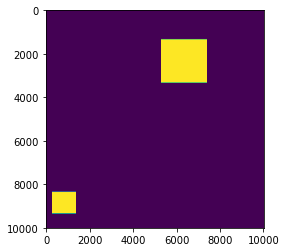

In [183]:
imshow(amask)

In [184]:
#type(src)


In [185]:
#type(bands)

In [83]:
#m3mask = rioxarray(mmask)

In [ ]:
#import numpy as np

In [186]:
#plt.imshow(m4mask)


In [187]:
#type(m4mask)

In [188]:
#m3mask.set_spatial_dims('x','y')




In [189]:
print(bands.rio.nodata)

None


In [190]:
print(amask.rio.nodata)

None


In [191]:
_add_attrs_proj(amask,bands[0])

<xarray.DataArray (y: 10002, x: 10004)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
Coordinates:
  * y            (y) float64 -2.667e+05 -2.667e+05 ... -3.667e+05 -3.667e+05
  * x            (x) float64 -1.654e+06 -1.654e+06 ... -1.554e+06 -1.554e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B4_first', 'B3_first', 'B2_first')
    grid_mapping:  spatial_ref

In [192]:
amask

<xarray.DataArray (y: 10002, x: 10004)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
Coordinates:
  * y            (y) float64 -2.667e+05 -2.667e+05 ... -3.667e+05 -3.667e+05
  * x            (x) float64 -1.654e+06 -1.654e+06 ... -1.554e+06 -1.554e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B4_first', 'B3_first', 'B2_first')
    grid_mapping:  spatial_ref

In [ ]:
del(bands)

In [ ]:
amask.rio.set_crs(bands[0].rio.crs)

In [ ]:
amask.rio.crs

In [92]:
bb=bands[0]

In [94]:
bb.size

100060008

In [99]:
import numpy as np

In [102]:
cc=np.array([[1,2],[3,4]])

In [103]:
type(cc)

numpy.ndarray

In [196]:
bands[0]

<xarray.DataArray (y: 10002, x: 10004)>
[100060008 values with dtype=uint16]
Coordinates:
    band         int64 1
  * y            (y) float64 -2.667e+05 -2.667e+05 ... -3.667e+05 -3.667e+05
  * x            (x) float64 -1.654e+06 -1.654e+06 ... -1.554e+06 -1.554e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B4_first', 'B3_first', 'B2_first')
    grid_mapping:  spatial_ref

In [194]:
amask

<xarray.DataArray (y: 10002, x: 10004)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
Coordinates:
  * y            (y) float64 -2.667e+05 -2.667e+05 ... -3.667e+05 -3.667e+05
  * x            (x) float64 -1.654e+06 -1.654e+06 ... -1.554e+06 -1.554e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B4_first', 'B3_first', 'B2_first')
    grid_mapping:  spatial_ref

In [ ]:
bb.rio.y_dim

In [193]:
out=merge_arrays([bands[0],amask])

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
bmask = mmask.copy()

In [ ]:
type(bmask)

In [ ]:
bmask.where                                                                                            mb,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,(bmask == True) =1
